In [83]:
from torch.distributions import Categorical


In [1]:
import gym
from gym.wrappers import FrameStack, GrayScaleObservation
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack
from stable_baselines3.common.callbacks import CheckpointCallback
import torch
import dubins
import numpy as np
import matplotlib.pyplot as plt
import random


In [2]:
class Drone:
    def __init__(self, x=0, y=0, theta=45, Destroy=0, drone_id=None):
        self.x = x
        self.y = y
        self.theta = theta
        self.id = drone_id
        

        ##规划问题留给
        # self.Tg = T_tg  # 决定goal的坐标
        # self.Tc = T_tc  # 决定规划的角度
        self.Destroy = Destroy
        self.velocity = 0.35
        self.num_missle = 2
        self.omega = 0 ##角速度
        self.max_omega = 10
        self.path = []
        self.name =drone_id
        # 感知信息
        self.friends = {}  # 使用字典存储队友信息
        self.enemies = []  # 敌方的信息
        self.fire_path=[]

        # # 决策信息
        # self.X = np.array(enemy_drone)  # 敌人攻击决策
        # self.Y = np.zeros((num_enemies, num_tactics))  # 战术选择

    def move(self, time_step):
        if self.Destroy == 0: 
            self.path.append((self.x,self.y))
            self.x += self.velocity * np.cos(np.radians(self.theta)) * time_step
            self.y += self.velocity * np.sin(np.radians(self.theta)) * time_step
            self.theta = (self.theta + self.omega * time_step) % 360

    def fire_missile(self, target):
        """发射导弹并影响目标飞机的状态"""
        reward = 0  # 初始化奖励
        if self.num_missle > 0:
            if target.Destroy == 0:  # 如果目标存活
                # print(f"{self.name}: 正在发射导弹...")
                self.num_missle -= 1  # 发射导弹后，A飞机导弹数量减少
                reward +=target.receive_attack(self)  # 目标被击落，状态更新为0 如果敌方发射，我方受损，敌方加分
                self.fire_path.append([(self.x,self.y),(target.x,target.y)])
                # reward += 5  # 发射导弹奖励
                # print(f"{self.name}: 导弹发射成功，剩余导弹数量: {self.num_missle}")
                # print(f"{target.name}: 状态更新为0，已被击落。\n")
            else:
                pass# print(f"{self.name}: 目标{target.name}已被击落，无法再发射导弹。\n")
        else:
            pass
            # print(f"{self.name}: 导弹已用尽，无法发射。\n")
        return reward

    def receive_attack(self, attacker):
        """根据攻击者与目标飞机的距离决定攻击是否成功"""
        reward = 0  # 初始化惩罚
        # 计算两架飞机之间的距离
        distance = self.calculate_distance(attacker)
        
        # 根据距离计算成功率（距离越近成功率越高）
        success_rate = self.calculate_success_rate(distance)
        # print(f"{self.name}: 距离 {distance:.2f}，成功率为 {success_rate}%")
        
        # 随机生成一个0到100之间的数，判断是否成功
        if random.randint(0, 100) <= success_rate:
            self.Destroy = 1  # 被击落
            reward -= 5  # 被击中惩罚
            # print(f"{self.name}: 被攻击击落！\n")
        else:
            pass
            # print(f"{self.name}: 攻击未命中，继续存活。\n")
        
        return reward 

    def calculate_distance(self, attacker):
        """计算两架飞机之间的欧几里得距离"""
        return math.sqrt((self.x - attacker.x)**2 + (self.y - attacker.y)**2)

    def calculate_success_rate(self, distance):
        """根据距离计算攻击成功率"""
        # 映射距离与成功率，距离10时成功率50%，距离3时成功率80%
        if distance >= 10:
            return 50
        elif distance <= 3:
            return 80
        else:
            # 距离范围在[3, 10]之间，根据比例计算成功率
            return 50 + (80 - 50) * (10 - distance) / 7        
        

In [3]:
###有效的目标和战术都是1、2、3
from scipy.spatial import distance

class Myplane(Drone):
    def __init__(self, x=0, y=0, theta=45, Destroy=0, drone_id=None, T_tg=0, T_tc=0, num_tactics=3):
        super().__init__(x, y, theta, Destroy,  drone_id)
        self.T_tg = T_tg
        self.T_tc = T_tc
        self.num_tactics = num_tactics
        self.dubins_path = []
        self.last_args = None
        self.desired_theta =0
        self.angle_error = 0

        self.dubins_lable = 0


        self.Kp = 1.0  # 比例增益
        self.Ki = 0.1  # 积分增益
        self.Kd = 0.05  # 微分增益

        self.previous_error = 0  # 上一次的误差
        self.integral = 0  # 积分部分
        
    def lock_plane(self,planes):
        reward = 0
        for plane in planes:
            dx = plane.x - self.x
            dy = plane.y - self.y            
            distance = math.sqrt(dx**2 + dy**2)
            target_angle = math.degrees(math.atan2(dy, dx))

            target_angle = (target_angle + 360) % 360
            drone_angle = (self.theta + 360) % 360
            
            # 计算角度差
            angle_diff = abs(target_angle - drone_angle)
            angle_diff = min(angle_diff, 360 - angle_diff)
            
            # 检查目标是否在角度和距离范围内
            if angle_diff <= 45 and distance <= 10:
                self.fire_missile(plane)
                reward += self.fire_missile(plane)  # 发射导弹后奖励

        return reward

   

    def plan_road(self,T_tg,T_tc,enemy_planes):
        ##先不判断是否到达某个距离才规划
        self.enemy_postion=[enemy_planes[T_tg-1].x,enemy_planes[T_tg-1].y]
        # print(f'敌方战机位置{self.enemy_postion}')
        if (T_tg,T_tc) == self.last_args:
            # print("战术策略与上次相同，不更新路径")
            return
        if T_tg !=0 and T_tc !=0:
            self.last_args =(T_tg,T_tc)
            if T_tc == 1:
                goal_postion_x = enemy_planes[T_tg-1].x -80
                goal_postion_y = enemy_planes[T_tg-1].y -80
                goal_theta     = enemy_planes[T_tg-1].theta
                goal_postion   = (goal_postion_x,goal_postion_y,np.deg2rad(goal_theta))##暂时就以这个作为向后攻击的坐标
                self_postion   = (self.x,self.y,np.deg2rad(self.theta))

            ##右突击
            if T_tc == 2:
                goal_postion_x = enemy_planes[T_tg-1].x - 70
                goal_postion_y = enemy_planes[T_tg-1].y - 70
                goal_theta     = enemy_planes[T_tg-1].theta +90
                goal_postion   = (goal_postion_x,goal_postion_y,np.deg2rad(goal_theta))
                self_postion   = (self.x,self.y,np.deg2rad(self.theta))

            ###左突击
            if T_tc == 3:
                goal_postion_x = enemy_planes[T_tg-1].x - 60
                goal_postion_y = enemy_planes[T_tg-1].y - 70
                goal_theta     = enemy_planes[T_tg-1].theta - 90
                goal_postion   = (goal_postion_x,goal_postion_y,np.deg2rad(goal_theta))
                self_postion   = (self.x,self.y,np.deg2rad(self.theta))

            
            turning_radius = 10 ###这个圆和 飞机的角速度很有关系，角速度很小，小弯转不了

            # 生成最短路径
            path = dubins.shortest_path(self_postion, goal_postion, turning_radius)
            
            # 采样路径上的点
            configurations, _ = path.sample_many(0.3)  # 采样间隔为0.1
            
            # 提取 x, y 坐标
            x_coords = [config[0] for config in configurations]
            y_coords = [config[1] for config in configurations]
            self.dubins_path = configurations

    def plan_road2(self,T_tg,T_tc,enemy_planes):
        enemy_plane=enemy_planes[T_tg-1]
        self.enemy_postion=[enemy_planes[T_tg-1].x,enemy_planes[T_tg-1].y]
        turning_radius = 10 ###这个圆和 飞机的角速度很有关系，角速度很小，小弯转不了
        distance1 = math.sqrt((self.x - self.enemy_postion[0])**2 + (self.y - self.enemy_postion[1])**2)
        turning_radius = max(distance1/150 * turning_radius,3)
        # print(f'敌方战机位置{self.enemy_postion}')
        if (T_tg,T_tc) == self.last_args:
            # print("战术策略与上次相同，不更新路径")
            return
        if T_tg !=0 and T_tc !=0:
            self.last_args =(T_tg,T_tc)
            if T_tc == 1:
                # goal_postion_x = enemy_planes[T_tg-1].x -80
                # goal_postion_y = enemy_planes[T_tg-1].y -80
                B_point =self.enemy_postion
                A_point =[0,0]
                A_point[0] = enemy_plane.velocity * np.cos(np.radians(enemy_plane.theta)) * 1000
                A_point[1] = enemy_plane.velocity * np.sin(np.radians(enemy_plane.theta)) * 1000
        
                sampling_points = np.linspace(A_point, B_point, num=20)
                goal_theta     = enemy_planes[T_tg-1].theta

                selected_point = []
                dubins_path = []
                diff_length = 1000
                for point in sampling_points:
                    goal_postion   = (point[0],point[1],np.deg2rad(goal_theta))##暂时就以这个作为向后攻击的坐标
                    self_postion   = (self.x,self.y,np.deg2rad(self.theta))
                    path = dubins.shortest_path(self_postion, goal_postion, turning_radius)
                    path_len=path.path_length()
                    path_len2=distance.euclidean((point[0],point[1]),(B_point[0],B_point[1]))
                    abs_diff = abs(path_len -path_len2)
                    if abs_diff <diff_length:
                        selected_point = point
                        diff_length = abs_diff
                        dubins_path , _= path.sample_many(0.3)
                self.dubins_path =dubins_path


            if T_tc == 2:
                # goal_postion_x = enemy_planes[T_tg-1].x -80
                # goal_postion_y = enemy_planes[T_tg-1].y -80
                B_point =self.enemy_postion
                A_point =[0,0]
                sampling_points = np.linspace(A_point, B_point, num=20)
                goal_theta     = enemy_planes[T_tg-1].theta +90

                selected_point = []
                dubins_path = []
                diff_length = 1000
                for point in sampling_points:
                    goal_postion   = (point[0],point[1],np.deg2rad(goal_theta))##暂时就以这个作为向后攻击的坐标
                    self_postion   = (self.x,self.y,np.deg2rad(self.theta))
                    path = dubins.shortest_path(self_postion, goal_postion, turning_radius)
                    path_len=path.path_length()
                    path_len2=distance.euclidean((point[0],point[1]),(B_point[0],B_point[1]))
                    abs_diff = abs(path_len -path_len2)
                    if abs_diff <diff_length:
                        selected_point = point
                        diff_length = abs_diff
                        dubins_path , _= path.sample_many(0.3)
                self.dubins_path =dubins_path

            if T_tc ==3:
                # goal_postion_x = enemy_planes[T_tg-1].x -80
                # goal_postion_y = enemy_planes[T_tg-1].y -80
                B_point =self.enemy_postion
                A_point =[0,0]
                sampling_points = np.linspace(A_point, B_point, num=20)
                goal_theta     = enemy_planes[T_tg-1].theta -90

                selected_point = []
                dubins_path = []
                diff_length = 1000
                for point in sampling_points:
                    goal_postion   = (point[0],point[1],np.deg2rad(goal_theta))##暂时就以这个作为向后攻击的坐标
                    self_postion   = (self.x,self.y,np.deg2rad(self.theta))
                    path = dubins.shortest_path(self_postion, goal_postion, turning_radius)
                    path_len=path.path_length()
                    path_len2=distance.euclidean((point[0],point[1]),(B_point[0],B_point[1]))
                    abs_diff = abs(path_len -path_len2)

                    if abs_diff <diff_length:
                        selected_point = point
                        diff_length = abs_diff
                        dubins_path , _= path.sample_many(0.3)
                self.dubins_path =dubins_path

    
    def move_along_omega(self):
        if not self.dubins_path:
            return

        if self.dubins_lable <= len(self.dubins_path)-1:
            target_x, target_y, target_theta = self.dubins_path[self.dubins_lable]


        while self.dubins_lable < len(self.dubins_path):
            self.desired_theta = np.degrees(np.arctan2(target_y - self.y, target_x - self.x))
            self.angle_error = (self.desired_theta - self.theta + 180) % 360 - 180
            
            distance = math.sqrt((self.x - target_x)**2 + (self.y - target_y)**2)
            if distance < 0.5:  # 当距离小于0.5时更新路径标签，抛弃过近的引导点
                self.dubins_lable += 1
                # print(f"plane{self.name}:dubins_lable{self.dubins_lable}---{len(self.dubins_path)}")
                if self.dubins_lable >= len(self.dubins_path): ###引导点终止在最后一个点
                    self.dubins_lable = len(self.dubins_path) - 1
                    # print('完成规划路线-------------------------------------------')
                    return
                target_x, target_y, target_theta = self.dubins_path[self.dubins_lable]
            else:
                break
        if self.dubins_lable >= len(self.dubins_path)-1:

            target_x,target_y=self.enemy_postion
            
        distance = math.sqrt((self.x - target_x)**2 + (self.y - target_y)**2)

            
        self.desired_theta = np.degrees(np.arctan2(target_y - self.y, target_x - self.x))
        self.angle_error = (self.desired_theta - self.theta + 180) % 360 - 180  # 角度差，限制在[-180, 180]
        self.integral += self.angle_error  # 积分
        derivative = self.angle_error - self.previous_error  # 微分（误差变化速率）
        
        # self.omega +=  self.angle_error * 0.01  # 控制增益可以调整
        omega_control = self.Kp * self.angle_error + self.Ki * self.integral + self.Kd * derivative
        
        # 更新角速度（omega）
        self.omega = omega_control
        # self.omega=self.angle_error * 0.05
        self.omega = max(min(self.omega, self.max_omega), -self.max_omega)  # 限制最大角速度
        # self.dubins_path.pop(0)

        self.previous_error = self.angle_error

        # if self.dubins_lable == len(self.dubins_path)-1:
        #     self.omega = 0

In [4]:
class Enemy_plane(Drone):
    def __init__(self, x=100, y=100, theta=135, Destroy=0, drone_id=None):
        super().__init__(x, y, theta, Destroy, drone_id)
    #     self.attack_history = {}

    # def record_attack(self, attacker, tactic):
    #     """记录攻击者使用的战术"""
    #     if attacker.name not in self.attack_history:
    #         self.attack_history[attacker.name] = []
    #     self.attack_history[attacker_id].append(tactic)
    ##发现锁定目标，开火
    def lock_plane(self,planes):
        reward =0
        for plane in planes:
            dx = plane.x - self.x
            dy = plane.y - self.y            
            distance = math.sqrt(dx**2 + dy**2)
            target_angle = math.degrees(math.atan2(dy, dx))

            target_angle = (target_angle + 360) % 360
            drone_angle = (self.theta + 360) % 360
            
            # 计算角度差
            angle_diff = abs(target_angle - drone_angle)
            angle_diff = min(angle_diff, 360 - angle_diff)
            
            # 检查目标是否在角度和距离范围内
            if angle_diff <= 45 and distance <= 10:
                reward +=self.fire_missile(plane)

        return reward


            


In [5]:
from collections import defaultdict

def count_unique_second_elements(two_d_list):
    """
    统计二维列表中，每个第一个元素对应的第二个元素不同的种类数。

    :param two_d_list: List of lists，每个子列表包含至少两个元素
    :return: 字典，键为第一个元素，值为第二个元素的不同种类数
    """
    # 使用 defaultdict 来自动处理不存在的键
    groups = defaultdict(set)
    
    for sublist in two_d_list:
        if len(sublist) < 2:
            continue  # 跳过不符合条件的子列表
        first_elem = sublist[0]
        second_elem = sublist[1]
        groups[first_elem].add(second_elem)
    
    # 计算每个组的种类数
    result = {key: len(value) for key, value in groups.items()}
    
    return result

In [6]:
import matplotlib.cm as cm

class AirFightEnv(gym.Env):
    def __init__(self):
        super().__init__()  # Python 3 推荐写法
        ###观测空间暂时不写
        self.num_Fplanes = 3
        ##列表化无人机装备
        # self.friendly_drones = Myplane(x=0, y=0, theta=45, drone_id=1)
        self.friendly_drones =[Myplane(x=i*10,y=i*10,theta=45,drone_id=i) for i in range(self.num_Fplanes) ]
        # self.enemy_drones = Enemy_plane(x=80, y=80, theta=225, drone_id=2)
        self.enemy_drones =[Enemy_plane(x=100,y=100,theta=225,drone_id ='A'),Enemy_plane(x=90,y=100,theta=225,drone_id ='B'),Enemy_plane(x=100,y=90,theta=225,drone_id ='C')]
        
        
        #暂时都是一架
        self.friendly_drone = self.friendly_drones[0]
        self.enemy_drone =self.enemy_drones[0]
        
        self.time_step = 1  # 每次step为1秒
        # 初始化状态
        self.state = None
        self.last_action = None
        self.mylast_Destroy = [0 for i in range(len(self.friendly_drones))]
        self.enemy_last_Destroy = [0 for i in range(len(self.enemy_drones))]
        self.reset()
        
    def reset(self):
                # 重置环境状态
        self.friendly_drones =[Myplane(x=i*10,y=i*10,theta=45,drone_id=i) for i in range(self.num_Fplanes) ]
        self.enemy_drones =[Enemy_plane(x=100,y=100,theta=225,drone_id ='A'),Enemy_plane(x=90,y=100,theta=225,drone_id ='B'),Enemy_plane(x=100,y=90,theta=225,drone_id ='C')]
        self.enemy_drone =self.enemy_drones[0]
        self.mylast_Destroy = [0 for i in range(len(self.friendly_drones))]
        self.enemy_last_Destroy = [0 for i in range(len(self.enemy_drones))]

        state = []
        # 初始化状态向量
        for drone in self.friendly_drones:
                o_drone = []

                for other_drone in self.friendly_drones:
                    if other_drone != drone:
                        o_drone.append(np.array([other_drone.x-drone.x, other_drone.y-drone.y, other_drone.theta-drone.theta, other_drone.T_tg,other_drone.T_tc,other_drone.Destroy]))
                    else:
                        o_drone.append(np.array([0,0,0,other_drone.T_tg,other_drone.T_tc,other_drone.Destroy]))
                for enemy_drone in self.enemy_drones:
                    o_drone.append(np.array([enemy_drone.x-drone.x, enemy_drone.y-drone.y, enemy_drone.theta-drone.theta,enemy_drone.Destroy]))
                state.append(o_drone)
        
        # 将状态转化为 numpy 数组
        self.state = np.array(state,dtype=object)
        self.last_action = None

        
        
        return self.state

    def step(self,action):
        self.action = action
        reward = 0
        reward -=1

        ##奖励9 多方向攻击
        counts = count_unique_second_elements(action)
        conditional_sum = sum(value for value in counts.values() if value > 1)
        reward += conditional_sum
        ##1切换目标惩罚
        if self.last_action != action:
            if self.last_action != None:
                
                for action_i in action:
                    if action_i[0] != self.last_action[0]:
                        reward -=3
                    else:
                        if action_i[1] != self.last_action[1]:
                            reward -=1
         ##惩罚4   同一敌机同一方向             
        for i in range(len(action)):
            action_i = action[i]
            for j in range(i+1,len(action)):
                if action_i == action[j]:
                    reward -=1
        ##5遗漏目标惩罚      
        target_list = []     
        for action_i in action:
            
            target_number = action_i[0]
            target_list.append(target_number)
        unique_target = set(target_list)
        miss_pen=len(self.enemy_drones)-len(unique_target) 
        reward -=miss_pen

        ##如果这个时刻被摧毁



        tatic_list = []
        #输入我方无人机的目标和战术
        goal_number = 1
        enemy_drone1= self.enemy_drone
        # print('敌方战机单个',enemy_drone1.x,enemy_drone1.y)
        # mydrone = self.friendly_drones[0]
        i=0
        for plane in self.friendly_drones:
            plane.T_tc =action[i][1]
            plane.T_tg = action[i][0]
            
            
            plane.plan_road2(action[i][0],action[i][1],self.enemy_drones)
            plane.move_along_omega()
            plane.move(self.time_step)
            reward+= plane.lock_plane(self.enemy_drones)
            
            i+=1

     
        for enemy_drone in self.enemy_drones:
            enemy_drone.move(self.time_step)
            reward -= enemy_drone.lock_plane(self.friendly_drones)
        state = []

        ##观测空间  

        for drone in self.friendly_drones:
            o_drone = []

            for other_drone in self.friendly_drones:
                if other_drone != drone:
                    o_drone.append(np.array([other_drone.x-drone.x, other_drone.y-drone.y, other_drone.theta-drone.theta, other_drone.T_tg,other_drone.T_tc,other_drone.Destroy]))
                else:
                    o_drone.append(np.array([0,0,0,other_drone.T_tg,other_drone.T_tc,other_drone.Destroy]))
            for enemy_drone in self.enemy_drones:
                o_drone.append(np.array([enemy_drone.x-drone.x, enemy_drone.y-drone.y, enemy_drone.theta-drone.theta,enemy_drone.Destroy]))
            state.append(o_drone)
            
        ##存活惩罚6、7
        # # 记录存活状况
        friendly_destroy = [drone.Destroy for drone in self.friendly_drones]
        enemy_destroy = [drone.Destroy for drone in self.enemy_drones]
        friendly_destroy_pen = sum(np.array(friendly_destroy)-np.array(self.mylast_Destroy))
        enemy_destroy_reward = sum(np.array(enemy_destroy)-np.array(self.enemy_last_Destroy))
        reward -= friendly_destroy_pen
        reward += enemy_destroy_reward



        
        # 将状态转化为 numpy 数组
        self.state = np.array(state,dtype=object)
        done = self.check_done()
            
        ###变换战术目标和战术惩罚
        self.last_action = action
        self.mylast_Destroy = friendly_destroy
        self.enemy_last_Destroy = enemy_destroy

        return self.state,reward,done,{'enemy_destroy_info':[done.Destroy*(-1)*10e+8 for done in self.enemy_drones],'enemy_drone_info':[enemy_drone for enemy_drone in self.enemy_drones]}
    def check_done(self):
        if all(drone.Destroy == 1 for drone in self.enemy_drones) or all(drone.Destroy == 1 for drone in self.friendly_drones):
            return True
        else:
            return False
    def render(self, mode='human'):
        plt.figure(figsize=(10, 10))
        target_list = [action_i[0] for action_i in self.action]
        colors = ['green', 'black', 'yellow']

        for i, target_i in enumerate(target_list):
            plt.scatter(self.enemy_drones[target_i-1].x +random.randint(0, 3), self.enemy_drones[target_i-1].y +random.randint(0, 3), 
                        color=colors[i], marker='^', s=50, label=f"Enemy Drone {self.enemy_drones[target_i-1].id}")

        for drone in self.friendly_drones:
            friendly_x, friendly_y = zip(*drone.path) if drone.path else ([], [])
            plt.plot(friendly_x, friendly_y, 'b-', label=f"Friendly Path{drone.name}")
            dubins_lable =drone.dubins_lable
            plt.scatter(drone.dubins_path[dubins_lable][0], drone.dubins_path[dubins_lable][1], color='blue', marker='^', s=100, label="Friendly Drone (point)")
    
    
            # 绘制规划路径
            if hasattr(drone, 'dubins_path') and drone.dubins_path:
                dubins_x = [point[0] for point in drone.dubins_path]
                dubins_y = [point[1] for point in drone.dubins_path]
                plt.plot(dubins_x, dubins_y, linestyle='--', label=f"Dubins Path{drone.id}")
        
            # 绘制当前己方无人机的位置和方向
            if drone:
                # print('我方坐标',drone.x, drone.y)
                # print('dubins',drone.dubins_path[0])
                # print(f'angle_info,期望角度{drone.desired_theta},实际角度{drone.theta},误差角度{drone.angle_error}，角速度{drone.omega}')
                if drone.Destroy == 0:
                    plt.quiver(
                        drone.x, drone.y,
                        np.cos(np.radians(drone.theta)), np.sin(np.radians(drone.theta)),
                        color='blue', scale=10, label="Friendly Drone"
                    )   
                else:
                    plt.scatter(drone.x, drone.y, color='blue', marker='x', s=100, label=f"Friendly Drone{drone.id}")   
            if drone.fire_path:
                x_coords, y_coords = zip(*drone.fire_path)
                plt.plot(x_coords, y_coords,  marker='x', linestyle='-', color='pink', label='Fire Path——my')



        
        # 绘制敌方无人机的路径
        for enemy_drone in self.enemy_drones:
            enemy_x, enemy_y = zip(*enemy_drone.path) if enemy_drone.path else ([], [])
            plt.plot(enemy_x, enemy_y, 'r-', label=f"Enemy Path{enemy_drone.id}")
        # 绘制当前敌方无人机的位置和方向
            if enemy_drone:
                if enemy_drone.Destroy == 0:    
                    plt.quiver(
                        enemy_drone.x, enemy_drone.y,
                        np.cos(np.radians(enemy_drone.theta)), np.sin(np.radians(enemy_drone.theta)),
                        color='red', scale=10, label=f"Enemy Drone{enemy_drone.id}"
                    )
                else:
                    plt.scatter(enemy_drone.x, enemy_drone.y, color='red', marker='x', s=100, label=f"Enemy Drone{enemy_drone.id}")
                if enemy_drone.fire_path:
                    x_coords, y_coords = zip(*enemy_drone.fire_path)
                    plt.plot(x_coords, y_coords, marker='o', linestyle='-',color='k', label=f'Fire Path——enemy{enemy_drone.id}')
                    print(enemy_drone.fire_path)
        
        
        # 设置图形属性
        plt.xlim(-10, 100)
        plt.ylim(-10, 100)
        plt.xlabel("X Position")
        plt.ylabel("Y Position")
        plt.title("Drone Path and Direction")
        plt.legend()
        plt.grid(True)
        
        # 显示图像
        if mode == 'human':
            display.clear_output(wait=True)  # 清除之前的输出
            display.display(plt.gcf())      # 显示当前图像
            plt.close()                     # 关闭图像以避免重复显示
        elif mode == 'rgb_array':
            plt.draw()
            plt.pause(0.01)
            return plt.gcf()

    def calculate_reward(self):
        pass
    


In [150]:
# 分离离散数据和连续数据
def separate_data(state):
    discrete_data = []
    continuous_data = []
    
    for row in state:
        discrete_row = []
        continuous_row = []
        for element in row:
            if len(element) == 6:
                discrete_row.append(np.array(element[3:], dtype=object))  # 后3个是离散数据
                continuous_row.append(np.array(element[:3], dtype=object))  # 前3个是连续数据
            elif len(element) == 4:
                discrete_row.append(np.array(element[3:], dtype=object))  # 最后1个是离散数据
                continuous_row.append(element[:3])  # 前3个是连续数据
        discrete_data.append(np.array(discrete_row, dtype=object))
        continuous_data.append(np.array(continuous_row, dtype=object))
    
    return np.array(discrete_data, dtype=object), np.array(continuous_data, dtype=object)

# 滑动标准化函数
def sliding_normalization(new_data, mean, variance, n):
    new_mean = mean + (new_data - mean) / (n + 1)
    new_variance = variance + (new_data - mean) * (new_data - new_mean)
    normalized_data = (new_data - new_mean) / np.sqrt(new_variance + 1e-8)  # 防止除以0
    return normalized_data, new_mean, new_variance

# 合并离散数据和标准化后的连续数据
def merge_data(discrete_data, normalized_continuous_data):
    processed_state = []
    for i in range(discrete_data.shape[0]):
        row = []
        for j in range(discrete_data.shape[1]):
            if len(discrete_data[i][j]) == 3:  # 长度为6的元素
                row.append(np.concatenate([normalized_continuous_data[i][j], discrete_data[i][j]]))
            elif len(discrete_data[i][j]) == 1:  # 长度为4的元素
                row.append(np.concatenate([normalized_continuous_data[i][j], discrete_data[i][j]]))
        processed_state.append(row)
    return np.array(processed_state, dtype=object)

In [7]:
# 分离离散数据和连续数据
def separate_data(state):
    discrete_data = []
    continuous_data = []
    
    
    for row in state:
        discrete_row = []
        continuous_row = []
        for element in row:
            element = np.array(element)  # 确保元素是 NumPy 数组
            if len(element) == 6:
                discrete_row.append(element[3:].astype(object))  # 后3个是离散数据
                continuous_row.append(element[:3].astype(float))  # 前3个是连续数据
            elif len(element) == 4:
                discrete_row.append(element[3:].astype(object))  # 最后1个是离散数据
                continuous_row.append(element[:3].astype(float))  # 前3个是连续数据
        discrete_data.append(np.array(discrete_row, dtype=object))
        continuous_data.append(np.array(continuous_row, dtype=float))
    
    return np.array(discrete_data, dtype=object), np.array(continuous_data, dtype=float)

# 滑动标准化函数
def sliding_normalization(new_data, mean, variance, n):
    new_mean = mean + (new_data - mean) / (n + 1)
    new_variance = variance + (new_data - mean) * (new_data - new_mean)
    normalized_data = (new_data - new_mean) / np.sqrt(new_variance + 1e-8)  # 使用 np.sqrt
    return normalized_data, new_mean, new_variance

# 合并离散数据和标准化后的连续数据
def merge_data(discrete_data, normalized_continuous_data):
    processed_state = []
    for i in range(discrete_data.shape[0]):
        row = []
        for j in range(discrete_data.shape[1]):
            if len(discrete_data[i][j]) == 3:  # 原始长度为6的元素
                merged = np.concatenate([normalized_continuous_data[i][j], discrete_data[i][j]])
                row.append(merged.astype(object))
            elif len(discrete_data[i][j]) == 1:  # 原始长度为4的元素
                merged = np.concatenate([normalized_continuous_data[i][j], discrete_data[i][j]])
                row.append(merged.astype(object))
        processed_state.append(np.array(row, dtype=object))
    return np.array(processed_state, dtype=object)
def process_vector1(vec):
    if len(vec) == 4:
        # 前3个元素 + 两个0 + 原第4个元素
        return np.array([vec[0], vec[1], vec[2], 0, 0, vec[3]], dtype=vec.dtype)
    else:
        return vec  # 长度6的向量保持不变
def process_vector(original_data):
    processed_data=[]
    for row in original_data:
        new_row = []
        for element in row:
            new_element = process_vector1(element)
            new_row.append(new_element)
        processed_data.append(new_row)
    return processed_data

In [10]:
import torch.nn as nn
import torch.nn.functional as F


class TargetNetwork(nn.Module):  # 继承 nn.Module
    def __init__(self):
        super(TargetNetwork, self).__init__()
        # 定义网络层
        self.fc1 = nn.Linear(36, 64)  # 示例：输入维度 10，输出维度 20
        self.fc2 = nn.Linear(64, 3)   # 示例：输入维度 20，输出维度 1

    def forward(self, x):
        # 定义前向传播
        x = torch.relu(self.fc1(x))  # 激活函数
        x = self.fc2(x)
        return x

# 实例化模型
target_network = TargetNetwork()


In [71]:
class CombinedNetwork(nn.Module):
    def __init__(self):
        super(CombinedNetwork, self).__init__()
        # 第一部分：处理 7x6 输入
        self.flatten = nn.Flatten()  # 将 7x6 展平为 42 维向量
        self.fc1 = nn.Linear(7 * 6, 6)  # 全连接层，42 -> 6

        # 第二部分：处理 3x3 输入
        self.fc2 = nn.Linear(3, 6)  # 全连接层，3 -> 6
        self.fc3 = nn.Linear(3, 3)  # 全连接层，3 -> 3

    def forward(self, x1, x2):
        # 处理 7x6 输入
        x1=self.flatten(x1)
        print('nnx1',x1.shape)
        output1 = self.fc1(x1)  # 全连接层，42 -> 6
        output1 = output1  # 将输出 reshape 为 1x6

        # 处理 3x3 输入
        output2 = self.fc2(x2)  # 全连接层，3x3 -> 3x6
        x2_pooled = x2.mean(dim=0, keepdim=True)  # 全局平均池化，3x3 -> 1x3
        output3 = self.fc3(x2_pooled)  # 全连接层，1x3 -> 1x3

        dot_products = torch.sum(output1 * output2, dim=1)  # 逐元素相乘并求和

        output3_squeezed = output3.squeeze(0)  # 去掉第一个维度，形状从 (1, 3) -> (3,)
        result = dot_products * output3_squeezed  # 逐元素相乘
        return result
combined_network = CombinedNetwork()

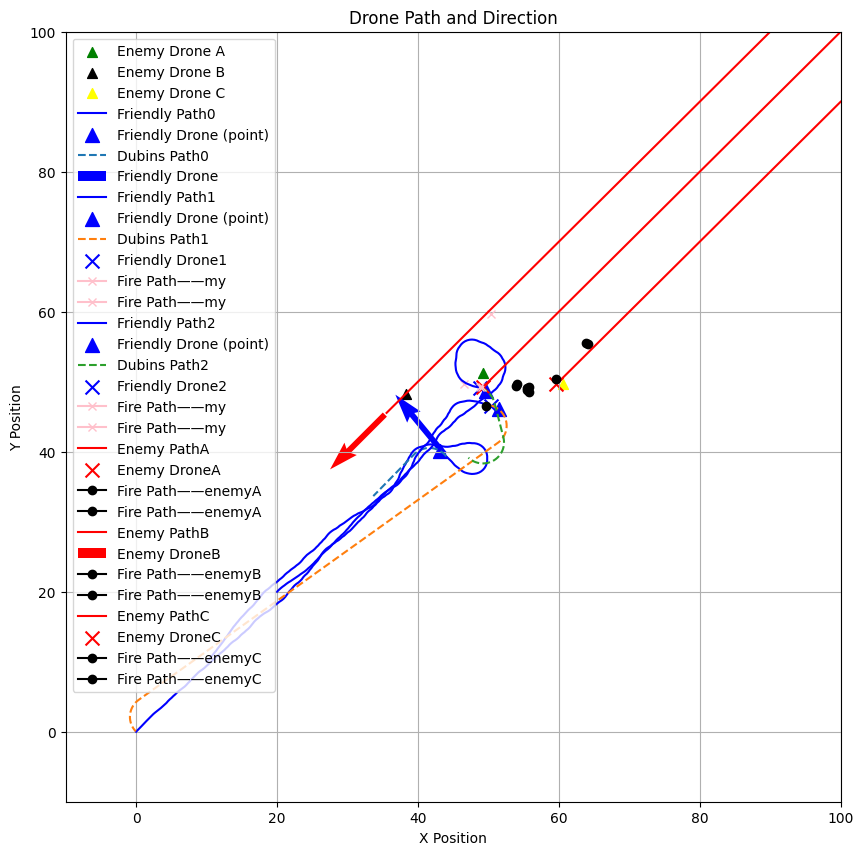

out_sate tensor([0, 1, 1])


In [84]:
import math
from IPython import display
env = AirFightEnv()
state = env.reset()
discrete_data, continuous_data = separate_data(state)
mean = np.zeros_like(continuous_data[0], dtype=float)
variance = np.ones_like(continuous_data[0], dtype=float)
normalized_continuous_data = np.zeros_like(continuous_data, dtype=float)

for n in range(1000):
    # action = env.action_space.sample()  # 随机选择一个动作
    a, b, c = random.sample([1, 2, 3], 3)
    t1, t2, t3 = random.sample([1, 2, 3], 3)

    action=[a,b,c]
    # state, reward, done, info = env.step([[1,1],[1,2],[1,3]])
    state, reward, done, info = env.step([[t1,action[0]],[t2,action[1]],[t3,action[2]]])
    ##process_continue_data
    discrete_data, continuous_data = separate_data(state)
    for i in range(continuous_data.shape[0]):
        for j in range(continuous_data.shape[1]):
            normalized_continuous_data[i][j], mean[j], variance[j] = sliding_normalization(
                continuous_data[i][j], mean[j], variance[j], n
            )
    processed_state = merge_data(discrete_data, normalized_continuous_data)
    processed_state=process_vector(processed_state)

    ###输入到神经网络里面去
    next_action_tg=[]
    # for plane_state in processed_state:
    #     plane_state=torch.tensor(plane_state, dtype=torch.float32)
    #     plane_state=plane_state.view(-1)
    #     print('plane_state.shape',plane_state.shape)
    #     output_state=target_network(plane_state).detach()
    #     output_state+=np.array(info['enemy_destroy_info'])

    #     output_action=F.softmax(output_state, dim=0)
    #     # action_choice=torch.argmax(output_action, dim=0)+1
    #     action_choice = torch.multinomial(output_action, num_samples=1).item() + 1

    #     print(action_choice)
    #     next_action_tg.append(action_choice)

    ###这些都放在combined newwork
    state_tensor = torch.tensor(processed_state,dtype=torch.float32)
    state_tensor = state_tensor.view(3,-1)
    output_state=target_network(state_tensor).detach()
    output_state+=np.array(info['enemy_destroy_info'])
    out_choice =F.softmax(output_state, dim=1)
    dist = Categorical(probs=out_choice)
    action_choice = dist.sample()
    print('out_sate',action_choice)

    #每个自己的状态、加上对应的action的观测的拼接， 每个自己状态-目标状态--战术--信息评判
    #当每个观测x 或者y为负的时候，战术后突击命中率最大、危险率最小【dis,m,w】、这些可以放在后面
    tac_info=[[40,0.8,0.8],[20,0.6,0.4],[20,0.6,0.4]] ##按照不同的情形，战术信息不一样
    





    for (i,tg) in enumerate(next_action_tg):
        o_i=processed_state[i]
        oij=state[i][2+tg]   ##找到当前己方对敌方的观测状态
        oij = np.pad(oij, (0, 2), mode='constant', constant_values=0)  # 填充 0      
        cat_state=np.concatenate((o_i,[oij]),axis=0)

        Tc_info = torch.tensor([
        [40 + random.randint(-10, 10), 0.8, 0.8],
        [20 + random.randint(-5, 5), 0.6, 0.4],
        [20 + random.randint(-5, 10), 0.6, 0.4]], dtype=torch.float32)  # 3x3 的输入
        cat_state = np.array([np.array(x) for x in cat_state], dtype=np.float32)

# 转换为 PyTorch 张量
        cat_state_tensor = torch.tensor(cat_state, dtype=torch.float32).unsqueeze(0)
        print(cat_state_tensor.shape)
    
        attention_score = combined_network(cat_state_tensor, Tc_info)
        print(attention_score)
            

    # print(np.array(processed_state).shape)
    
    ##三个己方飞机针对六个飞机的状态观测

       
    # print(np.array(processed_state))
    if done:
        break
    # state, reward, done, info = env.step([[1,action[0]],[1,action[1]],[1,action[2]]])

    env.render(mode='human')  # 显示图像
    # print(action)
   

   

   

In [ ]:
def process_vector1(vec):
    if len(vec) == 4:
        # 前3个元素 + 两个0 + 原第4个元素
        return np.array([vec[0], vec[1], vec[2], 0, 0, vec[3]], dtype=vec.dtype)
    else:
        return vec  # 长度6的向量保持不变
def process_vector(original_data):
    processed_data=[]
    for row in original_data:
        new_row = []
        for element in row:
            new_element = process_vector1(element)
            new_row.append(new_element)
        processed_data.append(new_row)
    return processed_data

In [19]:
print(np.array(o_i).shape)
print(len(oij))

(6, 6)


TypeError: object of type 'NoneType' has no len()

In [31]:
np.array(processed_state).shape

(3, 6, 6)

In [467]:
path = dubins.shortest_path((0,0,20), (20,20,50), 5)


In [69]:
continuous_data.shape

(3, 4, 3)

写一个ray训练cartpole的代码

In [30]:
print(state)

[[array([0, 0, 0, 2, 1, 0])
  array([ 9.79289527, 10.04290132, -1.59082842,  1.        ,  3.        ,
          0.        ])
  array([18.92919109, 20.9551585 ,  3.77718816,  3.        ,  2.        ,
          0.        ])
  array([ 61.75661389,  64.22359956, 184.32482899,   0.        ])
  array([ 51.75661389,  64.22359956, 184.32482899,   0.        ])
  array([ 61.75661389,  54.22359956, 184.32482899,   0.        ])]
 [array([ -9.79289527, -10.04290132,   1.59082842,   2.        ,
           1.        ,   0.        ])
  array([0, 0, 0, 1, 3, 0])
  array([ 9.13629582, 10.91225718,  5.36801658,  3.        ,  2.        ,
          0.        ])
  array([ 51.96371862,  54.18069824, 185.91565742,   0.        ])
  array([ 41.96371862,  54.18069824, 185.91565742,   0.        ])
  array([ 51.96371862,  44.18069824, 185.91565742,   0.        ])]
 [array([-18.92919109, -20.9551585 ,  -3.77718816,   2.        ,
           1.        ,   0.        ])
  array([ -9.13629582, -10.91225718,  -5.36801658

In [50]:
from collections import defaultdict

def count_unique_second_elements(two_d_list):
    """
    统计二维列表中，每个第一个元素对应的第二个元素不同的种类数。

    :param two_d_list: List of lists，每个子列表包含至少两个元素
    :return: 字典，键为第一个元素，值为第二个元素的不同种类数
    """
    # 使用 defaultdict 来自动处理不存在的键
    groups = defaultdict(set)
    
    for sublist in two_d_list:
        if len(sublist) < 2:
            continue  # 跳过不符合条件的子列表
        first_elem = sublist[0]
        second_elem = sublist[1]
        groups[first_elem].add(second_elem)
    
    # 计算每个组的种类数
    result = {key: len(value) for key, value in groups.items()}
    
    return result

# 示例使用
if __name__ == "__main__":
    data = [
        [1, 'a'],
        [1, 'b'],
        [1, 'a'],
        [2, 'x'],
        [2, 'y'],
        [2, 'z'],
        [3, 'm'],
        [3, 'm'],
        [3, 'n']
    ]
    
    counts = count_unique_second_elements(data)
    print(counts)  # 输出: {1: 2, 2: 3, 3: 2}

{1: 2, 2: 3, 3: 2}


In [89]:
k=torch.Tensor([1,2,3])
b=[1,2,3,4]
for (i,j) in enumerate(k):
    print(j)
    print(b[int(j.item())])

tensor(1.)
2
tensor(2.)
3
tensor(3.)
4
